Modèle Catboost avec Optuna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import optuna



c:\Users\lamou\Documents\GitHub\challenge_data_mining\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from catboost import CatBoostClassifier

import optuna


In [ ]:
#Importation des données clean
X_train=pd.read_csv("data/X_train_after_selection.csv")
y_train=pd.read_csv("data/y_train.csv")
X_val=pd.read_csv("data/X_val_after_selection.csv")
y_val=pd.read_csv("data/y_val.csv")
X_test=pd.read_csv("data/X_test.csv")

data_test = pd.read_csv("data/test.csv")

In [ ]:
categorical_features = ['IsActiveMember', 'Geography_Germany', 'Gender_Male']

for col in categorical_features:
    X_train[col] = X_train[col].astype('int')
    X_val[col] = X_val[col].astype('int')
    X_test[col] = X_test[col].astype('int')

In [14]:
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'iterations': trial.suggest_int('iterations', 100,1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        # 'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        # 'loss_function': 'Logloss',
        # 'random_state': 42,
        # 'cat_features': categorical_features,
        # 'auto_class_weights': 'Balanced',
        # 'verbose': 0
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50, verbose=0)

        y_val_pred = model.predict_proba(X_val_fold)[:, 1]
        val_auc = roc_auc_score(y_val_fold, y_val_pred)
        val_scores.append(val_auc)

    return np.mean(val_scores)

# Optimization avec Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300, n_jobs=-1)

print("Best parameters:", study.best_params)



[I 2024-12-31 19:07:14,016] A new study created in memory with name: no-name-f99854d6-6194-4c99-a9a9-7f4696b04b1c
[I 2024-12-31 19:07:21,512] Trial 6 finished with value: 0.9391252558432438 and parameters: {'depth': 4, 'iterations': 146, 'learning_rate': 0.0640903096911098, 'l2_leaf_reg': 0.001739950937628986}. Best is trial 6 with value: 0.9391252558432438.
[I 2024-12-31 19:07:24,688] Trial 11 finished with value: 0.9380011627102085 and parameters: {'depth': 5, 'iterations': 885, 'learning_rate': 0.08600556971486407, 'l2_leaf_reg': 0.01451171361981189}. Best is trial 6 with value: 0.9391252558432438.
[I 2024-12-31 19:07:25,876] Trial 3 finished with value: 0.9349333048401061 and parameters: {'depth': 7, 'iterations': 940, 'learning_rate': 0.07980212812777682, 'l2_leaf_reg': 0.007307101059709988}. Best is trial 6 with value: 0.9391252558432438.
[I 2024-12-31 19:07:28,179] Trial 10 finished with value: 0.9391951716793713 and parameters: {'depth': 4, 'iterations': 225, 'learning_rate': 0

In [15]:

best_params = study.best_params
best_params.update({
    'loss_function': 'Logloss',
    'cat_features': categorical_features,
    'verbose': 0,
    'auto_class_weights': 'Balanced'
})

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)

y_val_pred = final_model.predict_proba(X_val)[:, 1]
final_roc_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC AUC on Hold-out Set: {final_roc_auc:.4f}")



Validation ROC AUC on Hold-out Set: 0.9325


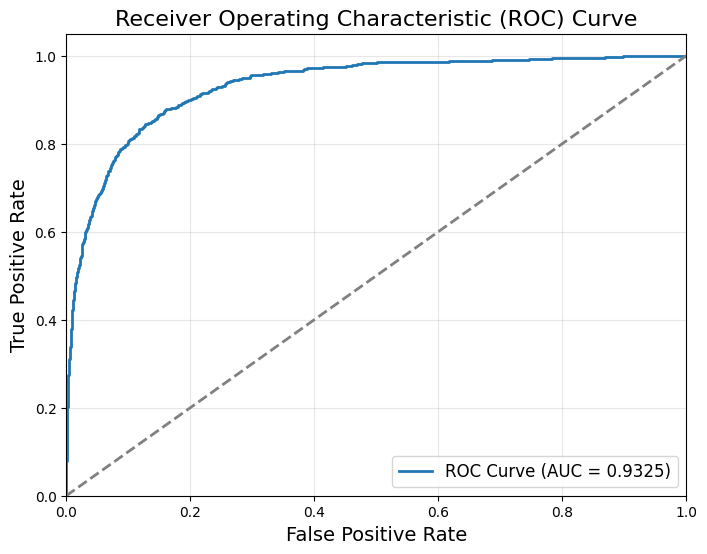

In [16]:

fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", lw=2)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()



In [7]:
# Prédictions sur le jeu de test
y_pred_proba_best = final_model.predict_proba(X_test)[:, 1]
sample_submission_test_N = data_test[['id']].copy()
sample_submission_test_N["Exited"] = y_pred_proba_best
sample_submission_test_N.to_csv("results_optuna.csv", index=False)
